In [1]:
from qiskit import Aer
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import SpinMapper, DirectMapper, LinearMapper, JordanWignerMapper
from qiskit.opflow import X, Y, Z, I
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.aer import StatevectorSimulator
from qiskit.utils import QuantumInstance
from qiskit_nature.algorithms import VQEUCCFactory

from qiskit.algorithms import VQE
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit

import pylab
import numpy as np
import retworkx as rx
from qiskit_nature.problems.second_quantization.lattice import (
    BoundaryCondition,
    IsingModel,
    FermiHubbardModel,
    HyperCubicLattice,
    Lattice,
    LatticeDrawStyle,
    LineLattice,
    SquareLattice,
    TriangularLattice,
)

from matplotlib.pyplot import figure
import time

Numpy 1.16 has memory leak bug  https://github.com/numpy/numpy/issues/13808
It is recommended to downgrade to numpy 1.15 or older


In [2]:
def findGroundState(pauliSumOp):
    return min(np.linalg.eigh(pauliSumOp.to_matrix())[0])

#Converts SpinOp to PauliSumOp
def convertSpin(ham):
    result = None
    spins = [I, Z, Y, X]
    for c, x, y, z in zip(ham._coeffs, ham.x, ham.y, ham.z):
        spin = x * 3 + y * 2 + z
        pauli = spins[spin[0]]
        for n in range(1, ham.register_length):
            pauli ^= spins[spin[n]]
        pauli *= c
        result = result + pauli if result else pauli
    return result

def makeLatticeIsing(size, cx):
    lattice = LineLattice(size, boundary_condition=BoundaryCondition.PERIODIC)

    t = 1.0  # the interaction parameter corresponds to Z
    v = cx  # the onsite potential corresponds to X

    ising = IsingModel.uniform_parameters(
        lattice=lattice,
        uniform_interaction=t, #interaction strength -- "hopping term"
        uniform_onsite_potential=v
    )
    return convertSpin(ising.second_q_ops())

def makeAnsatz(reps = 1, skip = True):
    return TwoLocal(
            rotation_blocks=["rx"],
            entanglement_blocks="rzz",
            entanglement="circular",
            skip_final_rotation_layer = skip,
            reps = reps,
            parameter_prefix="p",)

def findMin(ansatz, reps, cx):
    vqe_solver = VQE(
    ansatz = ansatz,
    quantum_instance=QuantumInstance(Aer.get_backend("aer_simulator_statevector")),)
    
    results = np.full(n, None)
    groundStates = np.full(n, 9999.9)
    times = np.full([n, reps], 0.0)
    for i in range(1, n):
        ising = makeLatticeIsing(i, cx)
        if ising:
            for j in range(reps):
                    result = vqe_solver.compute_minimum_eigenvalue(ising)
                    val = np.real(result.eigenvalue)
                    times[i][j]= result.optimizer_time
                    if val < np.real(groundStates[i]):
                        results[i] = result
                        groundStates[i] = val
                        print(f"Minimum   {i:>2}: {np.round(np.real(result.eigenvalue), 3):<7} " +
                              f"time: {round(result.optimizer_time, 2)}")
                    else:
                        print(f"Processed {i:>2}          time: {round(result.optimizer_time, 2)}")
    return results, groundStates, times

In [3]:
# define maximum size of system
n = 12
#define number of repetitions
r = 11
# Number of x-samples we have
s = 41

samples = [round(-2.0 + (4 * j/(s-1)), 5) for j in range(s)]
print(samples)

[-2.0, -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]


In [4]:
# Find True Groundstates of Model
trueGroundStates = np.full([s,n], 0.0)
trueTimes = np.full([s,n], 0.0)
for i, cx in enumerate(samples):
    print(f"X = {cx}:")
    for j in range(1, n):
        t1_start = time.time()
        trueGroundStates[i][j] = findGroundState(makeLatticeIsing(j, cx))
        trueTimes[i][j] =  time.time() - t1_start
        print(f"{j:>10}: {round(trueGroundStates[i][j],3):<7} time: {round(trueTimes[i][j],3)}")

X = -2.0:
         1: -2.0    time: 0.002
         2: -4.123  time: 0.008
         3: -6.292  time: 0.015
         4: -8.543  time: 0.013
         5: -10.62  time: 0.017
         6: -12.769 time: 0.024
         7: -14.886 time: 0.031
         8: -17.018 time: 0.051
         9: -19.143 time: 0.122
        10: -21.271 time: 0.583
        11: -23.398 time: 4.48
X = -1.9:
         1: -1.9    time: 0.001
         2: -3.929  time: 0.004
         3: -6.003  time: 0.009
         4: -8.176  time: 0.013
         5: -10.151 time: 0.018
         6: -12.213 time: 0.025
         7: -14.234 time: 0.034
         8: -16.274 time: 0.05
         9: -18.305 time: 0.133
        10: -20.341 time: 0.455
        11: -22.374 time: 6.442
X = -1.8:
         1: -1.8    time: 0.002
         2: -3.736  time: 0.006
         3: -5.715  time: 0.01
         4: -7.813  time: 0.014
         5: -9.686  time: 0.018
         6: -11.662 time: 0.027
         7: -13.587 time: 0.03
         8: -15.537 time: 0.11
         9: -17

         9: -7.49   time: 0.146
        10: -10.1   time: 0.648
        11: -9.51   time: 4.466
X = 0.3:
         1: -0.3    time: 0.001
         2: -1.166  time: 0.005
         3: -1.658  time: 0.008
         4: -4.093  time: 0.012
         5: -3.713  time: 0.016
         6: -6.136  time: 0.019
         7: -5.758  time: 0.024
         8: -8.181  time: 0.037
         9: -7.804  time: 0.118
        10: -10.226 time: 0.652
        11: -9.849  time: 4.528
X = 0.4:
         1: -0.4    time: 0.001
         2: -1.281  time: 0.012
         3: -1.898  time: 0.008
         4: -4.169  time: 0.012
         5: -3.999  time: 0.014
         6: -6.243  time: 0.018
         7: -6.083  time: 0.023
         8: -8.323  time: 0.038
         9: -8.164  time: 0.139
        10: -10.404 time: 0.643
        11: -10.245 time: 4.434
X = 0.5:
         1: -0.5    time: 0.001
         2: -1.414  time: 0.004
         3: -2.146  time: 0.009
         4: -4.272  time: 0.011
         5: -4.31   time: 0.014
         6: -

In [5]:
results = [None] * s
groundStates = [None] * s
times = [None] * s
print(groundStates)

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [6]:
ansatz = makeAnsatz(reps = 1)
for i, cx in enumerate(samples):
    print(f"X = {cx}:")
    results[i], groundStates[i], times[i] = findMin(ansatz, r, cx)

X = -2.0:
Minimum    1: 0.0     time: 0.12
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Minimum    2: -2.562  time: 0.16
Minimum    2: -2.562  time: 0.1
Processed  2          time: 0.1
Processed  2          time: 0.15
Minimum    2: -2.562  time: 0.08
Processed  2          time: 0.08
Minimum    2: -2.562  time: 0.13
Processed  2          time: 0.13
Processed  2          time: 0.11
Processed  2          time: 0.08
Processed  2          time: 0.14
Minimum    3: -4.327  time: 0.21
Processed  3          time: 0.4
Minimum    3: -4.327  time: 0.32
Processed  3          time: 0.25
Processed  3          time: 0.26
Processed  3          time: 0.24
Minimum    3: -4.327  time: 0.21
Processed  3          time: 0.35
Pro

Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Minimum    2: -2.368  time: 0.13
Minimum    2: -2.368  time: 0.1
Processed  2          time: 0.11
Processed  2          time: 0.11
Processed  2          time: 0.13
Minimum    2: -2.368  time: 0.09
Processed  2          time: 0.07
Processed  2          time: 0.08
Processed  2          time: 0.09
Processed  2          time: 0.08
Processed  2          time: 0.1
Minimum    3: -3.95   time: 0.26
Processed  3          time: 0.45
Minimum    3: -3.95   time: 0.34
Processed  3          time: 0.26
Processed  3          time: 0.41
Processed  3          time: 0.27
Processed  3          time: 0.35
Processed  3          time: 0.27
Processed  3          time: 0.23
Processed  3          time: 0.28
Processed  3          time: 0.19
Minimum    4: -6.118  time: 0.59
Minimum    4: -6.118  time: 0.57
Processed  4          time: 0.6
Minimum    4:

Minimum    2: -2.176  time: 0.24
Minimum    2: -2.176  time: 0.17
Processed  2          time: 0.34
Processed  2          time: 0.17
Processed  2          time: 0.19
Processed  2          time: 0.16
Processed  2          time: 0.16
Processed  2          time: 0.16
Processed  2          time: 0.15
Minimum    3: -3.576  time: 0.47
Minimum    3: -3.576  time: 0.51
Processed  3          time: 0.55
Minimum    3: -3.576  time: 0.52
Processed  3          time: 0.47
Processed  3          time: 0.54
Processed  3          time: 0.6
Processed  3          time: 0.61
Processed  3          time: 0.72
Processed  3          time: 0.49
Processed  3          time: 0.4
Minimum    4: -3.2    time: 0.81
Minimum    4: -5.774  time: 1.08
Processed  4          time: 1.73
Processed  4          time: 0.91
Minimum    4: -5.774  time: 1.16
Processed  4          time: 0.67
Processed  4          time: 0.77
Minimum    4: -5.774  time: 1.4
Processed  4          time: 0.62
Minimum    4: -5.774  time: 0.82
Minimum    4:

Minimum    2: -1.987  time: 0.23
Minimum    2: -1.987  time: 0.18
Processed  2          time: 0.22
Processed  2          time: 0.13
Minimum    3: -3.206  time: 0.78
Minimum    3: -3.206  time: 0.37
Minimum    3: -3.206  time: 0.56
Processed  3          time: 0.48
Processed  3          time: 0.9
Processed  3          time: 0.8
Processed  3          time: 0.63
Processed  3          time: 0.54
Processed  3          time: 0.53
Processed  3          time: 0.37
Processed  3          time: 0.44
Minimum    4: -5.441  time: 0.72
Processed  4          time: 0.85
Minimum    4: -5.441  time: 0.89
Minimum    4: -5.441  time: 1.41
Processed  4          time: 0.8
Processed  4          time: 0.74
Processed  4          time: 0.86
Processed  4          time: 1.31
Processed  4          time: 0.74
Processed  4          time: 0.74
Processed  4          time: 0.74
Minimum    5: -5.758  time: 1.07
Minimum    5: -5.758  time: 1.3
Minimum    5: -5.758  time: 1.79
Minimum    5: -5.758  time: 1.32
Processed  5  

Minimum    3: -2.842  time: 0.5
Processed  3          time: 0.59
Processed  3          time: 0.53
Processed  3          time: 0.47
Processed  3          time: 0.5
Processed  3          time: 0.49
Processed  3          time: 0.53
Processed  3          time: 0.52
Processed  3          time: 0.73
Minimum    4: -5.124  time: 0.93
Minimum    4: -5.124  time: 0.61
Minimum    4: -5.124  time: 0.72
Minimum    4: -5.124  time: 1.05
Processed  4          time: 0.63
Processed  4          time: 0.78
Processed  4          time: 0.76
Minimum    4: -5.124  time: 0.98
Minimum    4: -5.124  time: 1.73
Minimum    4: -5.124  time: 0.72
Processed  4          time: 0.68
Minimum    5: -5.268  time: 1.46
Processed  5          time: 1.25
Processed  5          time: 1.45
Processed  5          time: 1.11
Processed  5          time: 1.27
Minimum    5: -5.268  time: 1.2
Processed  5          time: 1.0
Minimum    5: -5.268  time: 1.46
Processed  5          time: 1.28
Processed  5          time: 1.15
Processed  5  

Minimum    3: -2.484  time: 0.65
Processed  3          time: 0.68
Processed  3          time: 0.45
Minimum    4: -4.828  time: 0.61
Processed  4          time: 0.73
Processed  4          time: 0.62
Processed  4          time: 0.9
Processed  4          time: 0.72
Processed  4          time: 0.83
Processed  4          time: 0.41
Processed  4          time: 0.77
Minimum    4: -4.828  time: 0.43
Processed  4          time: 0.74
Minimum    4: -4.828  time: 0.73
Minimum    5: -4.798  time: 1.3
Minimum    5: -4.798  time: 1.41
Minimum    5: -4.798  time: 1.6
Processed  5          time: 1.48
Processed  5          time: 1.05
Minimum    5: -4.798  time: 1.18
Processed  5          time: 1.18
Minimum    5: -4.798  time: 1.43
Processed  5          time: 1.73
Processed  5          time: 1.83
Minimum    5: -4.798  time: 1.47
Minimum    6: -6.986  time: 1.51
Processed  6          time: 1.18
Processed  6          time: 1.15
Processed  6          time: 1.29
Minimum    6: -7.243  time: 1.17
Processed  6 

Processed  4          time: 1.09
Minimum    4: -4.561  time: 0.76
Processed  4          time: 0.9
Processed  4          time: 0.76
Processed  4          time: 0.88
Processed  4          time: 0.47
Minimum    4: -4.561  time: 0.71
Processed  4          time: 0.77
Minimum    5: -4.351  time: 1.28
Minimum    5: -4.351  time: 1.28
Minimum    5: -4.351  time: 1.33
Processed  5          time: 1.61
Processed  5          time: 1.68
Processed  5          time: 2.05
Processed  5          time: 1.55
Processed  5          time: 1.78
Processed  5          time: 1.87
Processed  5          time: 1.36
Processed  5          time: 1.31
Minimum    6: -6.842  time: 1.06
Processed  6          time: 1.2
Processed  6          time: 1.69
Minimum    6: -6.842  time: 1.3
Processed  6          time: 1.56
Processed  6          time: 1.89
Processed  6          time: 2.26
Processed  6          time: 1.1
Processed  6          time: 1.43
Processed  6          time: 1.42
Processed  6          time: 1.9
Minimum    7: -

Processed  4          time: 0.49
Processed  4          time: 0.63
Minimum    5: -3.934  time: 0.94
Processed  5          time: 1.09
Minimum    5: -3.934  time: 1.38
Processed  5          time: 1.04
Processed  5          time: 1.22
Processed  5          time: 1.05
Processed  5          time: 1.09
Minimum    5: -3.934  time: 1.69
Processed  5          time: 1.45
Processed  5          time: 1.32
Processed  5          time: 1.9
Minimum    6: -6.499  time: 1.03
Minimum    6: -6.499  time: 1.0
Minimum    6: -6.499  time: 1.25
Processed  6          time: 0.88
Processed  6          time: 0.96
Processed  6          time: 0.65
Processed  6          time: 1.07
Processed  6          time: 0.95
Processed  6          time: 0.96
Minimum    6: -6.499  time: 1.17
Processed  6          time: 1.68
Minimum    7: -6.101  time: 2.43
Processed  7          time: 3.04
Minimum    7: -6.101  time: 2.2
Processed  7          time: 2.59
Processed  7          time: 1.49
Processed  7          time: 1.93
Minimum    7:

Processed  5          time: 1.66
Processed  5          time: 1.67
Processed  5          time: 1.77
Minimum    5: -3.558  time: 1.33
Minimum    5: -3.558  time: 1.52
Processed  5          time: 1.43
Minimum    5: -3.558  time: 1.39
Minimum    6: -6.231  time: 1.39
Processed  6          time: 2.0
Processed  6          time: 2.15
Processed  6          time: 1.25
Processed  6          time: 1.06
Processed  6          time: 1.11
Processed  6          time: 1.15
Minimum    6: -6.231  time: 1.47
Processed  6          time: 1.46
Minimum    6: -6.231  time: 1.8
Processed  6          time: 1.58
Minimum    7: -5.635  time: 3.25
Minimum    7: -5.635  time: 3.21
Processed  7          time: 3.04
Processed  7          time: 2.74
Processed  7          time: 2.02
Processed  7          time: 3.39
Processed  7          time: 3.07
Processed  7          time: 2.27
Processed  7          time: 3.74
Processed  7          time: 2.45
Processed  7          time: 2.62
Minimum    8: -8.308  time: 3.81
Minimum    8

Processed  5          time: 1.16
Processed  5          time: 1.51
Minimum    6: -6.045  time: 1.61
Minimum    6: -6.059  time: 1.85
Minimum    6: -6.059  time: 1.53
Minimum    6: -6.059  time: 1.5
Processed  6          time: 2.63
Minimum    6: -6.059  time: 2.74
Processed  6          time: 2.02
Processed  6          time: 2.07
Processed  6          time: 2.43
Processed  6          time: 1.29
Processed  6          time: 2.37
Minimum    7: -5.26   time: 4.1
Minimum    7: -5.26   time: 4.62
Processed  7          time: 4.12
Minimum    7: -5.26   time: 4.36
Processed  7          time: 4.31
Processed  7          time: 3.81
Processed  7          time: 5.28
Processed  7          time: 3.83
Processed  7          time: 4.39
Processed  7          time: 3.83
Processed  7          time: 4.04
Minimum    8: -4.465  time: 5.45
Minimum    8: -8.079  time: 4.84
Minimum    8: -8.079  time: 4.75
Processed  8          time: 6.1
Processed  8          time: 4.53
Processed  8          time: 5.84
Processed  8 

Processed  6          time: 0.39
Processed  6          time: 0.76
Processed  6          time: 0.63
Processed  6          time: 0.65
Processed  6          time: 0.56
Processed  6          time: 0.61
Processed  6          time: 0.62
Processed  6          time: 0.45
Minimum    7: -5.0    time: 1.0
Processed  7          time: 0.85
Processed  7          time: 0.99
Processed  7          time: 0.68
Processed  7          time: 0.76
Processed  7          time: 1.31
Processed  7          time: 0.86
Minimum    7: -5.0    time: 0.85
Processed  7          time: 0.94
Processed  7          time: 0.76
Minimum    7: -5.0    time: 1.02
Minimum    8: -4.0    time: 1.45
Minimum    8: -8.0    time: 1.25
Processed  8          time: 1.34
Processed  8          time: 1.15
Processed  8          time: 0.89
Processed  8          time: 1.79
Processed  8          time: 0.79
Processed  8          time: 1.01
Minimum    8: -8.0    time: 1.15
Processed  8          time: 1.71
Processed  8          time: 1.21
Minimum    

Processed  6          time: 3.49
Processed  6          time: 2.24
Processed  6          time: 2.21
Minimum    7: -5.26   time: 4.13
Minimum    7: -5.26   time: 4.88
Processed  7          time: 4.54
Processed  7          time: 4.16
Processed  7          time: 4.91
Processed  7          time: 3.9
Processed  7          time: 4.61
Processed  7          time: 4.2
Processed  7          time: 3.75
Minimum    7: -5.26   time: 5.06
Minimum    7: -5.26   time: 4.64
Minimum    8: -8.079  time: 4.9
Processed  8          time: 5.85
Processed  8          time: 5.47
Processed  8          time: 5.08
Processed  8          time: 5.67
Processed  8          time: 4.77
Processed  8          time: 4.87
Processed  8          time: 4.5
Processed  8          time: 5.01
Processed  8          time: 4.1
Processed  8          time: 3.31
Minimum    9: -7.28   time: 10.88
Minimum    9: -7.28   time: 10.94
Minimum    9: -7.28   time: 11.63
Processed  9          time: 8.91
Processed  9          time: 9.66
Minimum    9

Processed  7          time: 3.39
Processed  7          time: 4.24
Processed  7          time: 3.26
Processed  7          time: 3.21
Processed  7          time: 2.24
Processed  7          time: 2.99
Processed  7          time: 3.64
Processed  7          time: 3.45
Processed  7          time: 2.99
Minimum    8: -8.308  time: 2.65
Minimum    8: -8.308  time: 2.46
Processed  8          time: 2.59
Processed  8          time: 2.77
Processed  8          time: 4.51
Processed  8          time: 3.48
Processed  8          time: 4.6
Processed  8          time: 4.39
Processed  8          time: 3.52
Processed  8          time: 5.15
Processed  8          time: 3.72
Minimum    9: -7.712  time: 9.76
Minimum    9: -7.712  time: 7.92
Processed  9          time: 8.0
Processed  9          time: 7.7
Minimum    9: -7.712  time: 10.09
Processed  9          time: 7.67
Processed  9          time: 8.8
Processed  9          time: 7.38
Processed  9          time: 9.34
Processed  9          time: 5.62
Processed  9 

Minimum    7: -6.101  time: 3.43
Processed  7          time: 2.36
Processed  7          time: 3.18
Processed  7          time: 1.93
Minimum    8: -5.743  time: 3.11
Minimum    8: -8.665  time: 2.73
Processed  8          time: 2.74
Processed  8          time: 3.56
Processed  8          time: 4.92
Processed  8          time: 4.01
Minimum    8: -8.665  time: 3.25
Processed  8          time: 5.19
Minimum    8: -8.665  time: 2.84
Processed  8          time: 2.61
Processed  8          time: 2.95
Minimum    9: -8.267  time: 5.41
Minimum    9: -8.267  time: 8.01
Processed  9          time: 8.24
Processed  9          time: 4.02
Processed  9          time: 5.47
Processed  9          time: 5.04
Processed  9          time: 4.57
Processed  9          time: 6.92
Processed  9          time: 4.58
Processed  9          time: 4.94
Processed  9          time: 4.66
Minimum   10: -10.758 time: 13.64
Minimum   10: -10.831 time: 9.09
Processed 10          time: 14.04
Processed 10          time: 18.78
Process

Minimum    8: -9.122  time: 3.01
Processed  8          time: 2.48
Processed  8          time: 3.0
Processed  8          time: 4.22
Processed  8          time: 5.73
Processed  8          time: 1.98
Minimum    8: -9.122  time: 2.89
Minimum    8: -9.122  time: 2.64
Processed  8          time: 3.85
Processed  8          time: 3.65
Minimum    9: -8.913  time: 6.03
Minimum    9: -8.913  time: 7.34
Processed  9          time: 3.67
Processed  9          time: 7.08
Processed  9          time: 6.52
Processed  9          time: 3.69
Processed  9          time: 5.87
Processed  9          time: 5.79
Processed  9          time: 3.58
Minimum    9: -8.913  time: 6.76
Processed  9          time: 7.32
Minimum   10: -8.725  time: 23.54
Minimum   10: -8.78   time: 12.9
Minimum   10: -11.403 time: 10.89
Processed 10          time: 17.54
Minimum   10: -11.403 time: 10.19
Processed 10          time: 8.45
Processed 10          time: 10.5
Processed 10          time: 11.69
Processed 10          time: 12.37
Proce

Processed  8          time: 2.13
Minimum    8: -9.657  time: 2.49
Processed  8          time: 1.98
Processed  8          time: 3.41
Minimum    9: -9.628  time: 5.51
Processed  9          time: 5.15
Processed  9          time: 3.98
Processed  9          time: 6.49
Processed  9          time: 4.14
Processed  9          time: 3.35
Processed  9          time: 4.81
Processed  9          time: 5.11
Processed  9          time: 5.26
Processed  9          time: 3.72
Processed  9          time: 5.18
Minimum   10: -9.698  time: 7.36
Processed 10          time: 13.71
Minimum   10: -9.702  time: 12.62
Processed 10          time: 15.21
Processed 10          time: 13.79
Processed 10          time: 15.87
Minimum   10: -12.071 time: 10.16
Processed 10          time: 8.29
Processed 10          time: 15.63
Processed 10          time: 19.55
Processed 10          time: 14.21
Minimum   11: -12.042 time: 43.86
Processed 11          time: 50.22
Processed 11          time: 40.17
Processed 11          time: 57.

Processed  9          time: 4.65
Processed  9          time: 4.46
Minimum    9: -10.395 time: 7.46
Processed  9          time: 3.83
Processed  9          time: 5.52
Processed  9          time: 3.9
Minimum    9: -10.395 time: 4.2
Processed  9          time: 8.46
Processed  9          time: 4.45
Minimum   10: -10.502 time: 13.1
Minimum   10: -12.608 time: 11.15
Processed 10          time: 13.03
Processed 10          time: 11.48
Minimum   10: -12.81  time: 11.84
Processed 10          time: 11.59
Processed 10          time: 12.72
Processed 10          time: 12.3
Processed 10          time: 12.53
Processed 10          time: 11.02
Processed 10          time: 23.0
Minimum   11: -12.957 time: 51.18
Processed 11          time: 43.08
Processed 11          time: 52.73
Processed 11          time: 62.75
Processed 11          time: 36.77
Processed 11          time: 58.33
Processed 11          time: 41.23
Processed 11          time: 62.93
Processed 11          time: 44.8
Processed 11          time: 5

Processed  9          time: 3.91
Processed  9          time: 4.78
Processed  9          time: 5.45
Minimum   10: -11.515 time: 15.82
Minimum   10: -11.689 time: 12.26
Processed 10          time: 15.15
Minimum   10: -13.602 time: 13.26
Processed 10          time: 12.51
Processed 10          time: 19.67
Processed 10          time: 13.3
Processed 10          time: 17.66
Processed 10          time: 10.97
Processed 10          time: 13.57
Processed 10          time: 9.94
Minimum   11: -11.94  time: 36.83
Minimum   11: -13.924 time: 49.88
Processed 11          time: 47.57
Processed 11          time: 48.42
Processed 11          time: 38.33
Minimum   11: -13.924 time: 48.75
Processed 11          time: 48.04
Processed 11          time: 38.64
Processed 11          time: 37.84
Processed 11          time: 51.17
Processed 11          time: 29.68
X = 1.5:
Minimum    1: 0.0     time: 0.02
Processed  1          time: 0.02
Processed  1          time: 0.02
Processed  1          time: 0.01
Processed  1  

Minimum   10: -14.434 time: 4.1
Processed 10          time: 7.28
Processed 10          time: 6.26
Processed 10          time: 7.65
Processed 10          time: 9.07
Processed 10          time: 4.71
Processed 10          time: 6.02
Processed 10          time: 5.79
Minimum   11: -13.415 time: 17.85
Minimum   11: -14.93  time: 19.51
Processed 11          time: 22.14
Processed 11          time: 18.0
Processed 11          time: 21.43
Minimum   11: -14.93  time: 18.96
Processed 11          time: 19.17
Processed 11          time: 17.23
Processed 11          time: 30.9
Processed 11          time: 26.87
Processed 11          time: 28.9
X = 1.7:
Minimum    1: 0.0     time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time:

Processed 10          time: 5.22
Processed 10          time: 6.65
Minimum   11: -15.947 time: 26.89
Minimum   11: -15.947 time: 50.55
Processed 11          time: 38.48
Processed 11          time: 36.32
Processed 11          time: 33.45
Minimum   11: -15.947 time: 57.71
Processed 11          time: 53.84
Processed 11          time: 46.37
Minimum   11: -15.947 time: 39.61
Minimum   11: -15.968 time: 32.15
Processed 11          time: 49.27
X = 1.9:
Minimum    1: 0.0     time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Processed  1          time: 0.01
Minimum    2: -2.465  time: 0.09
Minimum    2: -2.465  time: 0.13
Processed  2          time: 0.09
Processed  2          time: 0.07
Processed  2          time: 0.16
Minimum    2: -2.465  t

Processed 11          time: 19.22
Processed 11          time: 20.9
Processed 11          time: 19.77
Processed 11          time: 18.0
Processed 11          time: 14.2
Processed 11          time: 12.66
Processed 11          time: 11.4


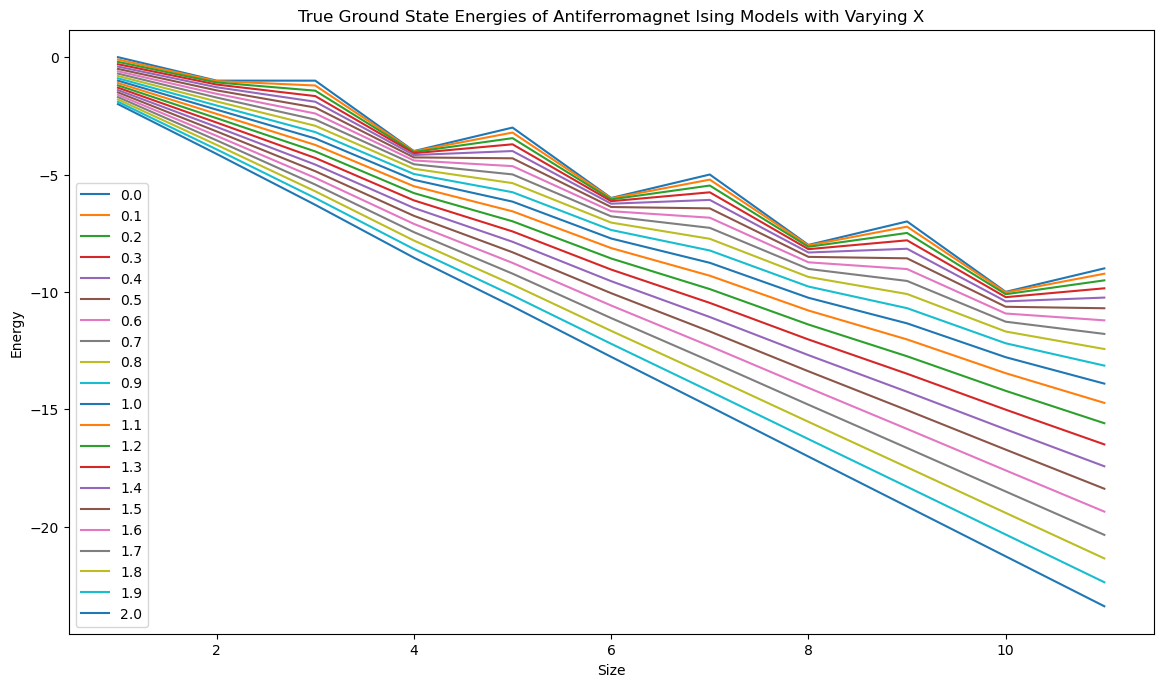

In [14]:
figure(figsize=(14, 8), dpi=100)

for i in range(s//2,s):
    pylab.plot(list(range(1, len(trueGroundStates[i]))), np.asarray(np.real(trueGroundStates[i][1:]), float), label=str(samples[i]))
pylab.xlabel('Size')
pylab.ylabel('Energy')
pylab.title('True Ground State Energies of Antiferromagnet Ising Models with Varying X')
pylab.legend(loc='lower left')

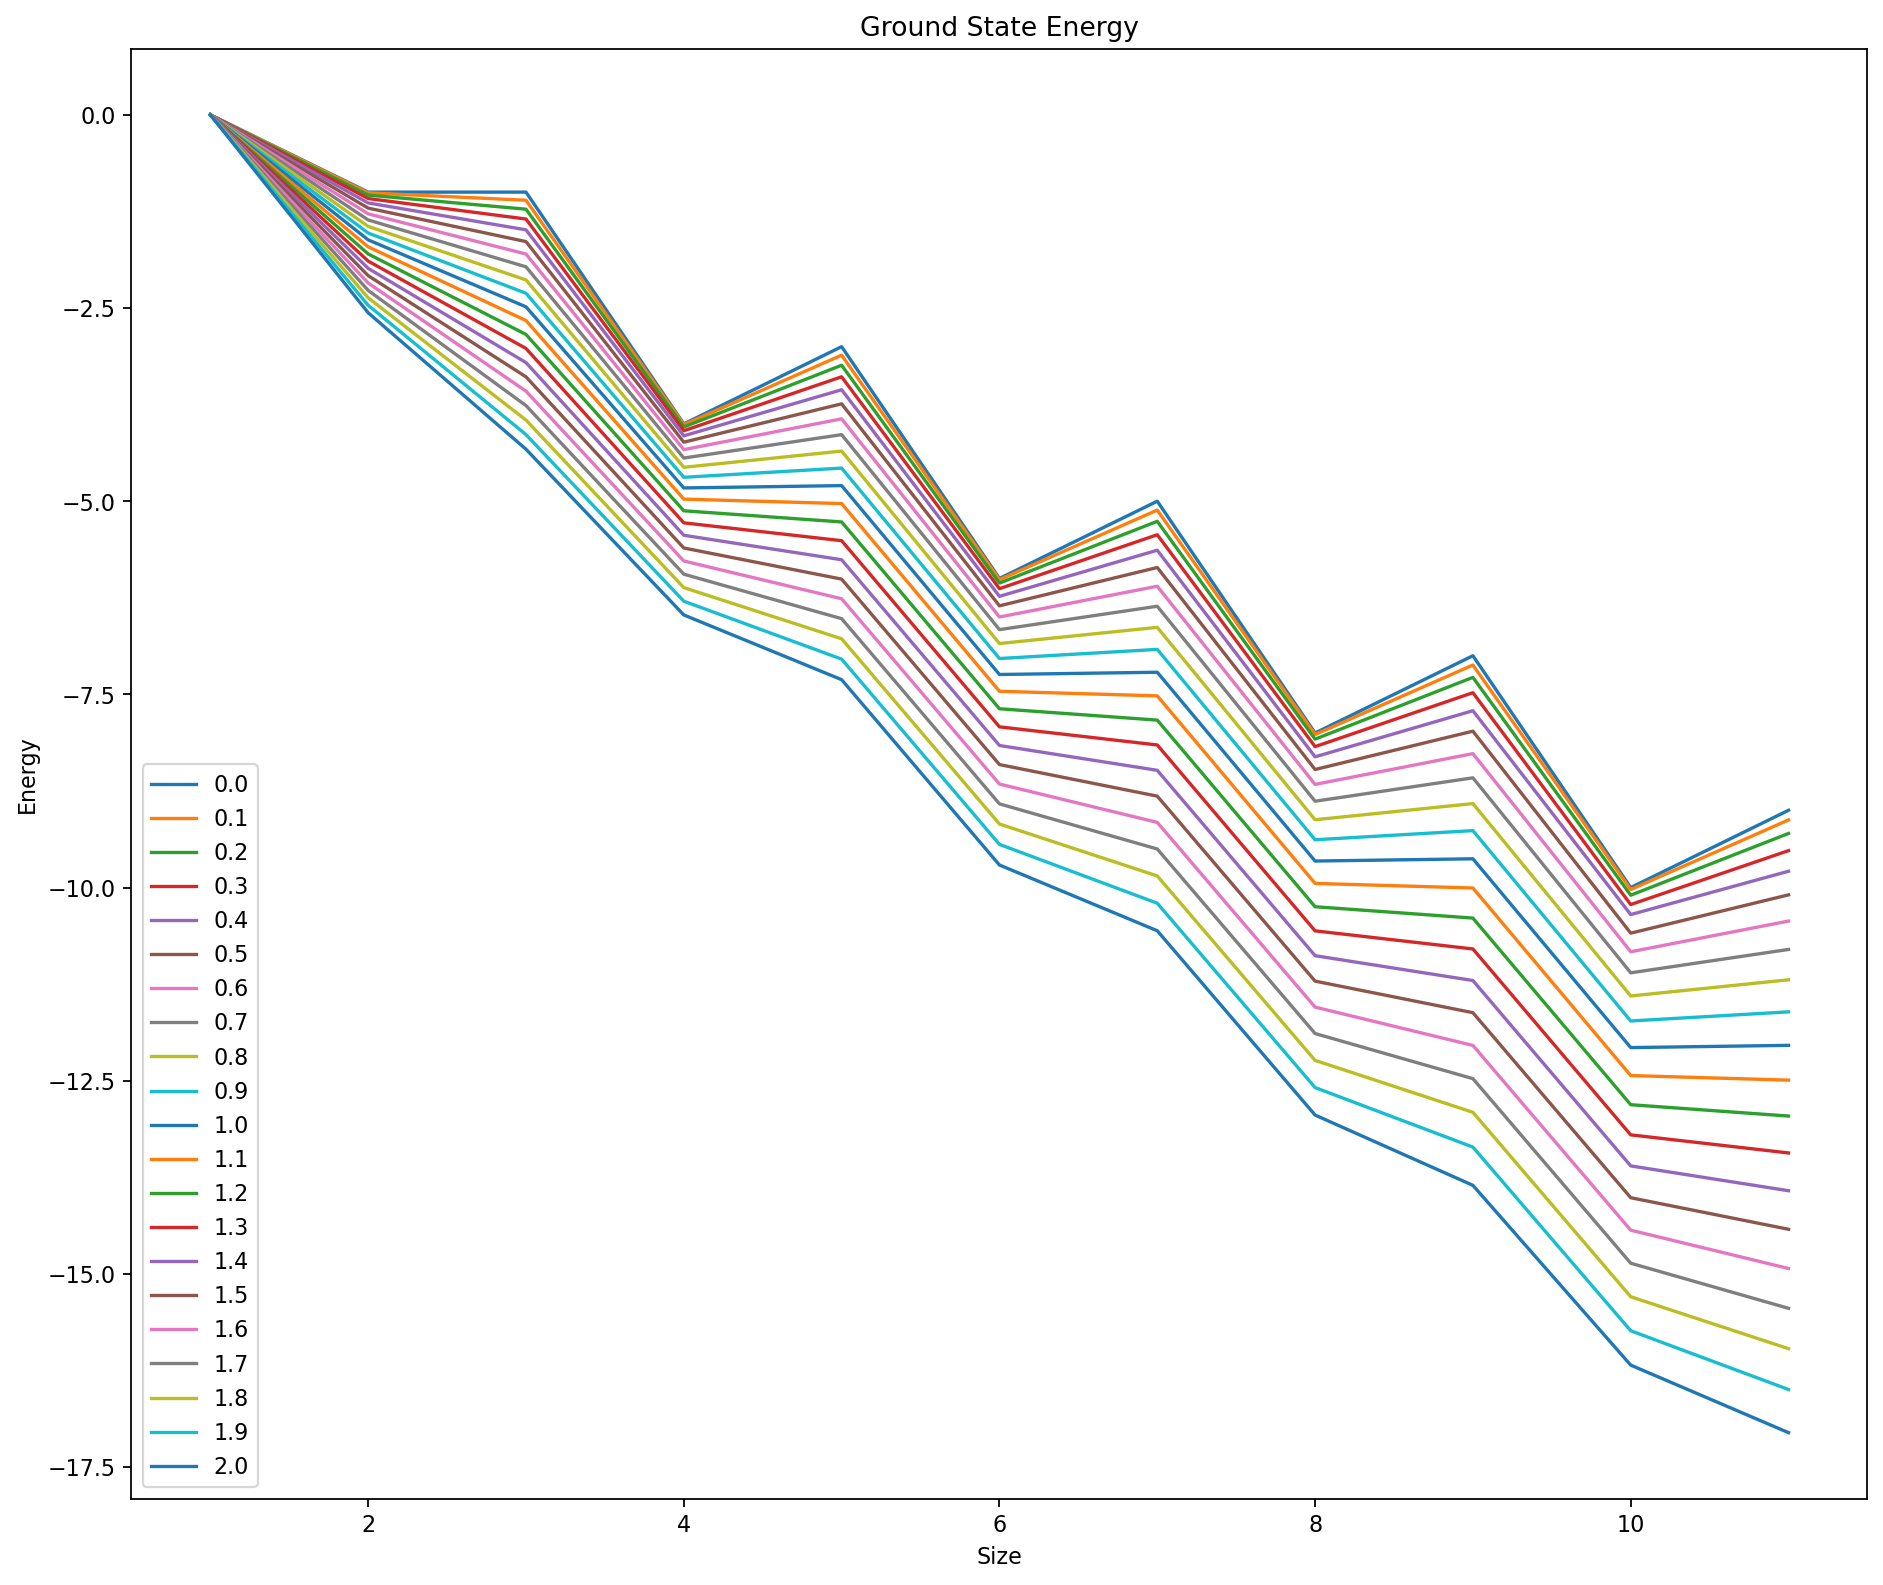

In [15]:
figure(figsize=(14, 12), dpi=160)

for i in range(s//2, s):
    pylab.plot(list(range(1, len(groundStates[i]))), np.asarray(np.real(groundStates[i][1:]), float), label=str(samples[i]))
pylab.xlabel('Size')
pylab.ylabel('Energy')
pylab.title('Ground State Energy')
pylab.legend(loc='lower left')

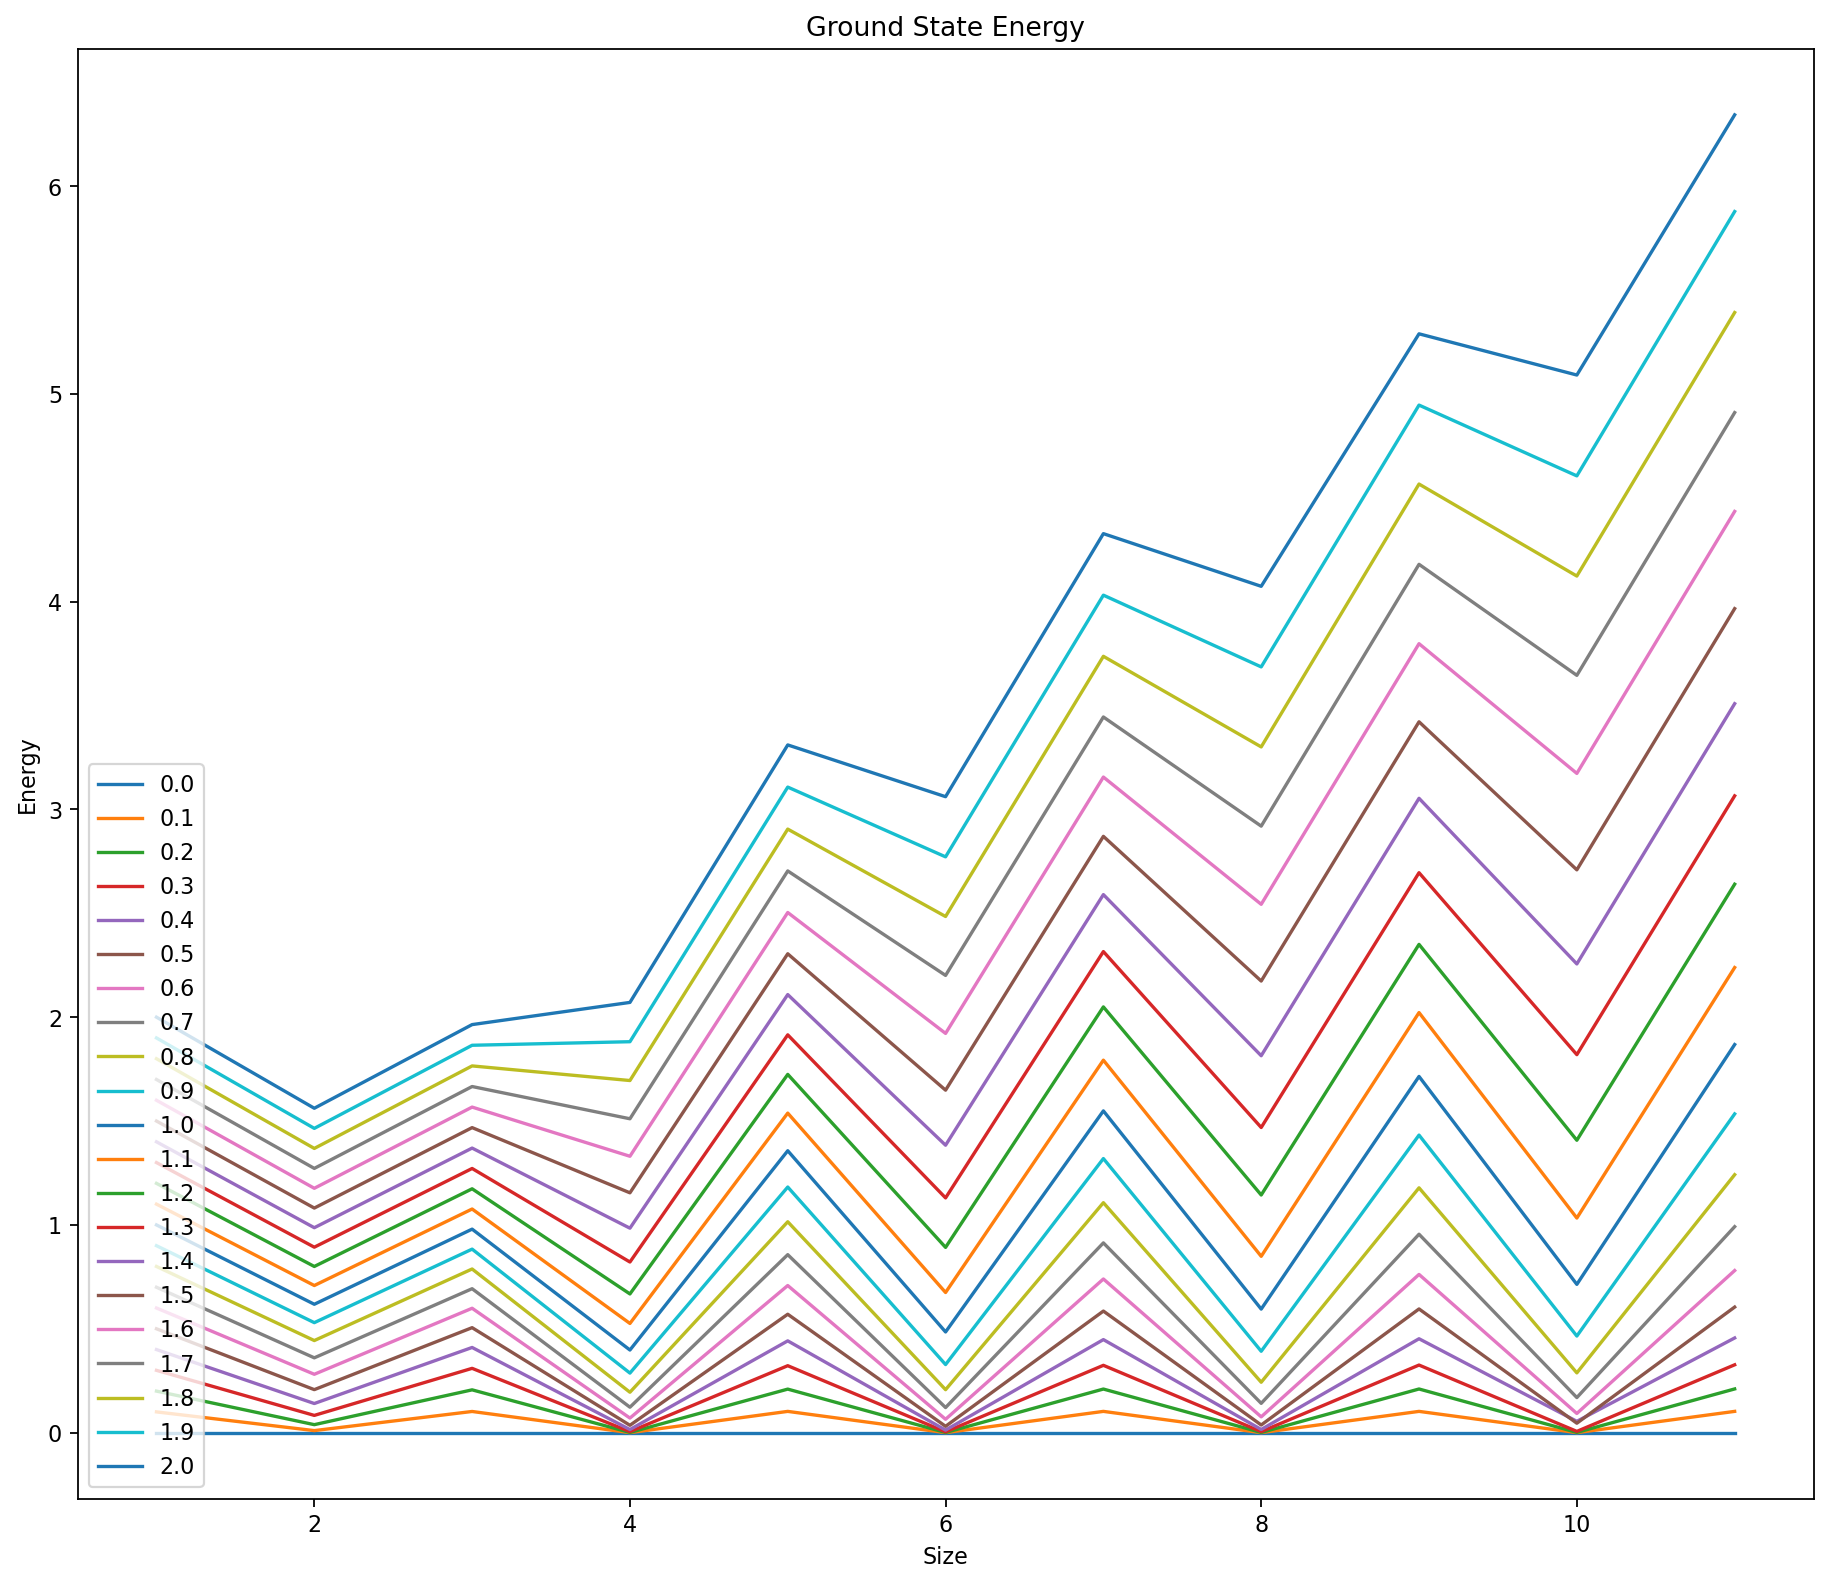

In [17]:
figure(figsize=(14, 12), dpi=160)

for i in range(s//2, s):
    diff = np.asarray(np.real(groundStates[i][1:]), float) - np.asarray(np.real(trueGroundStates[i][1:]), float)
    pylab.plot(list(range(1, len(groundStates[i]))), diff, label=str(samples[i]))
pylab.xlabel('Size')
pylab.ylabel('Energy')
pylab.title('Ground State Energy')
pylab.legend(loc='lower left')

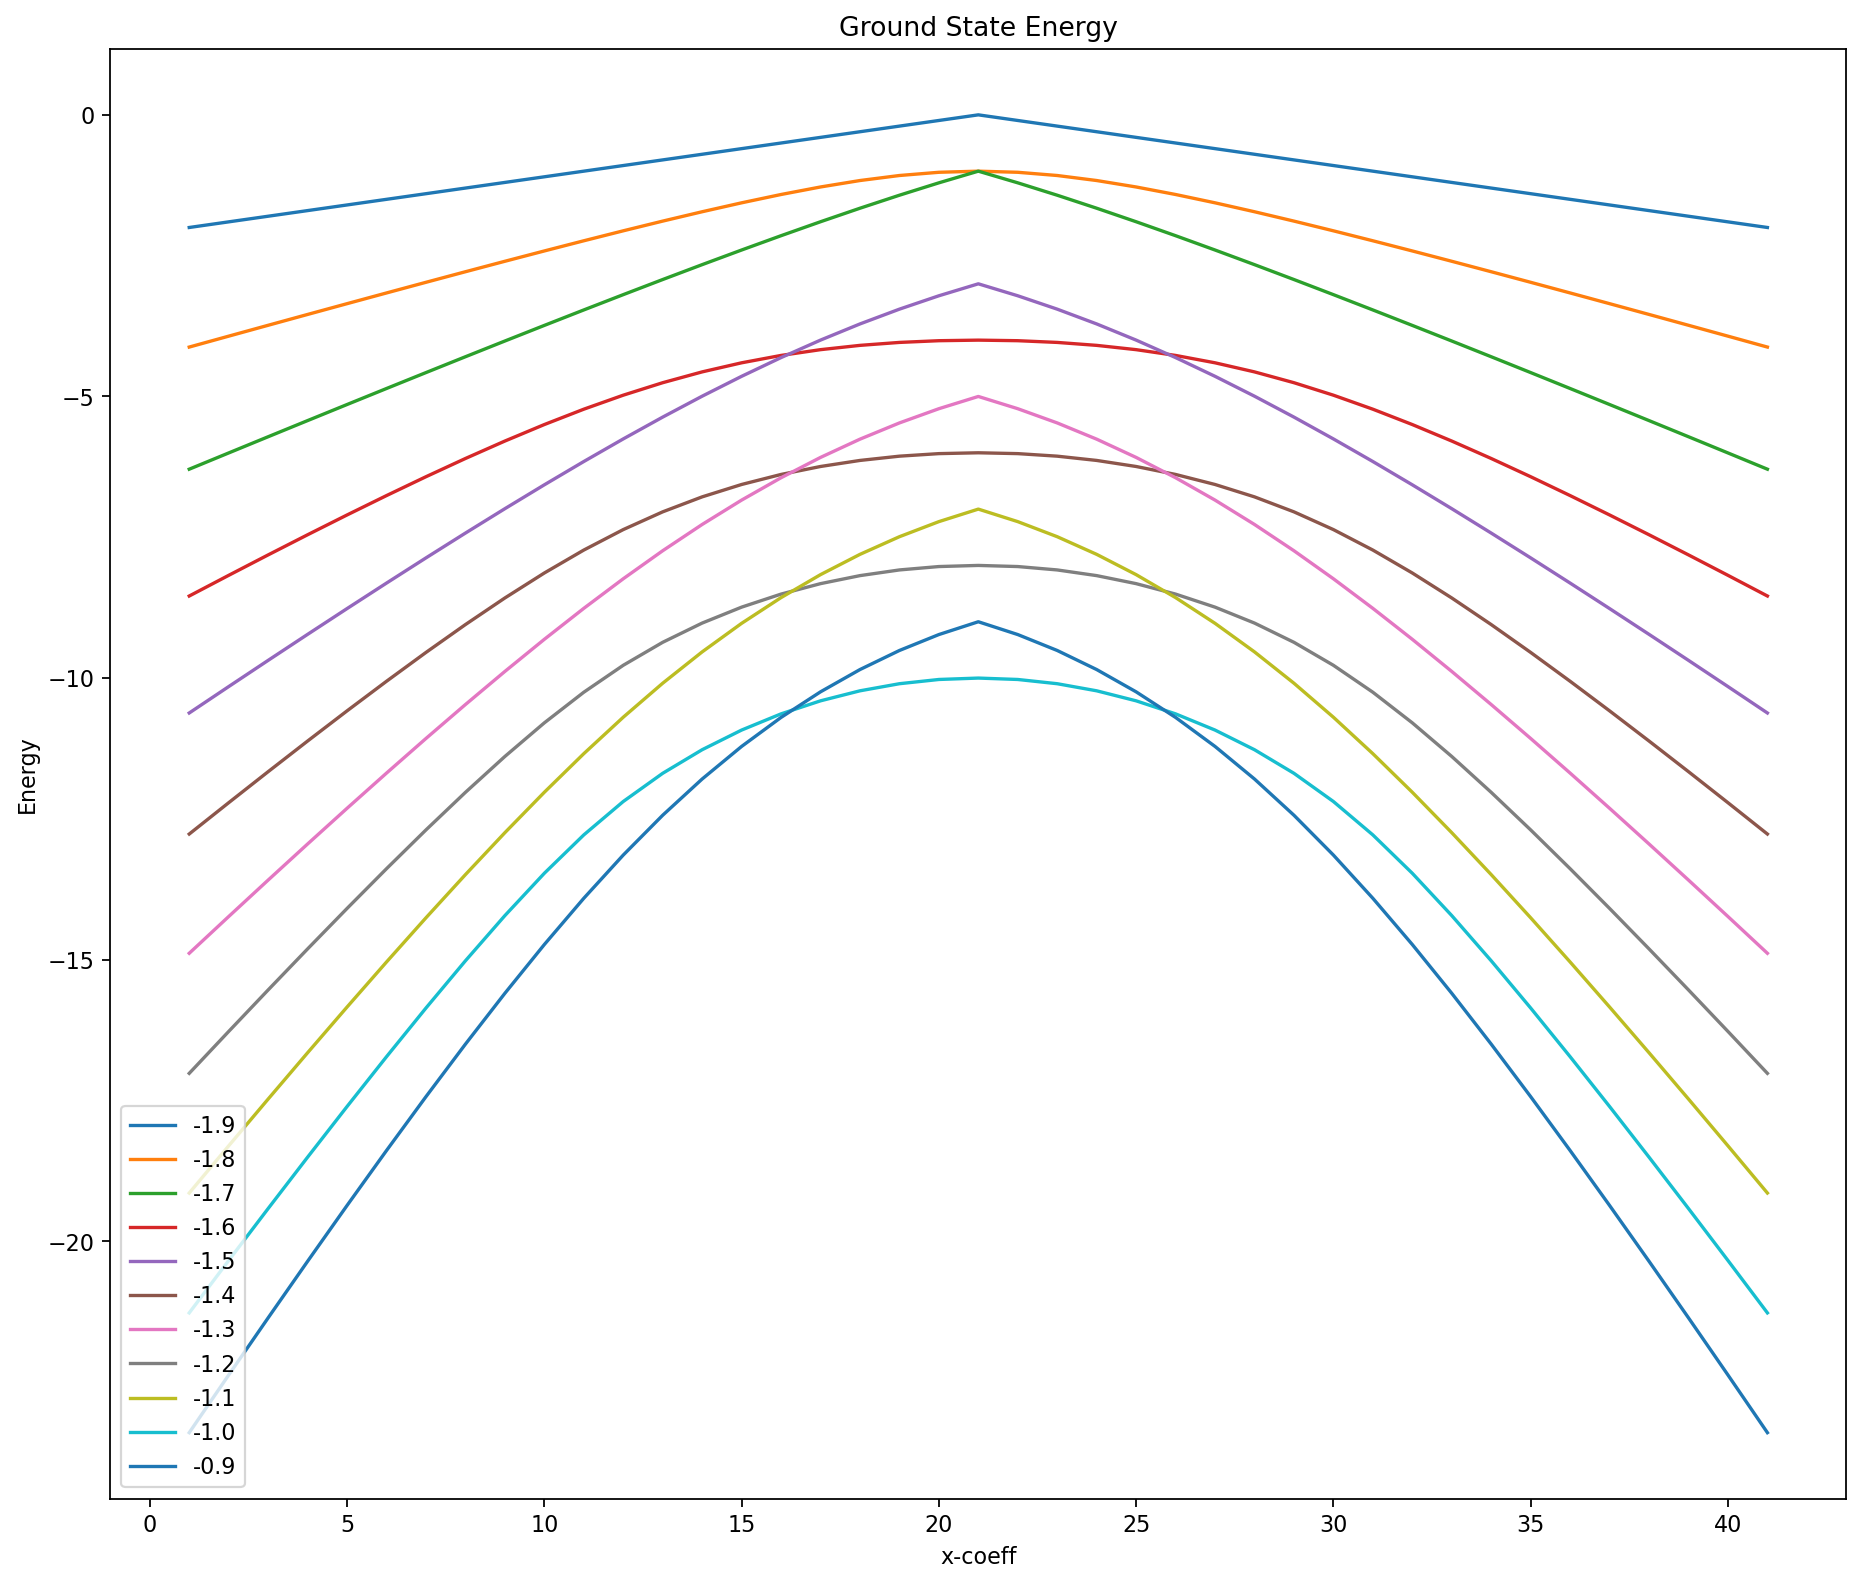

In [18]:
figure(figsize=(14, 12), dpi=160)

for i in range(1,12):
    pylab.plot(list(range(1, 42)), np.asarray(np.real(trueGroundStates[:, i])), label=str(samples[i]))
                                              
pylab.xlabel('x-coeff')
pylab.ylabel('Energy')
pylab.title('Ground State Energy')
pylab.legend(loc='lower left')

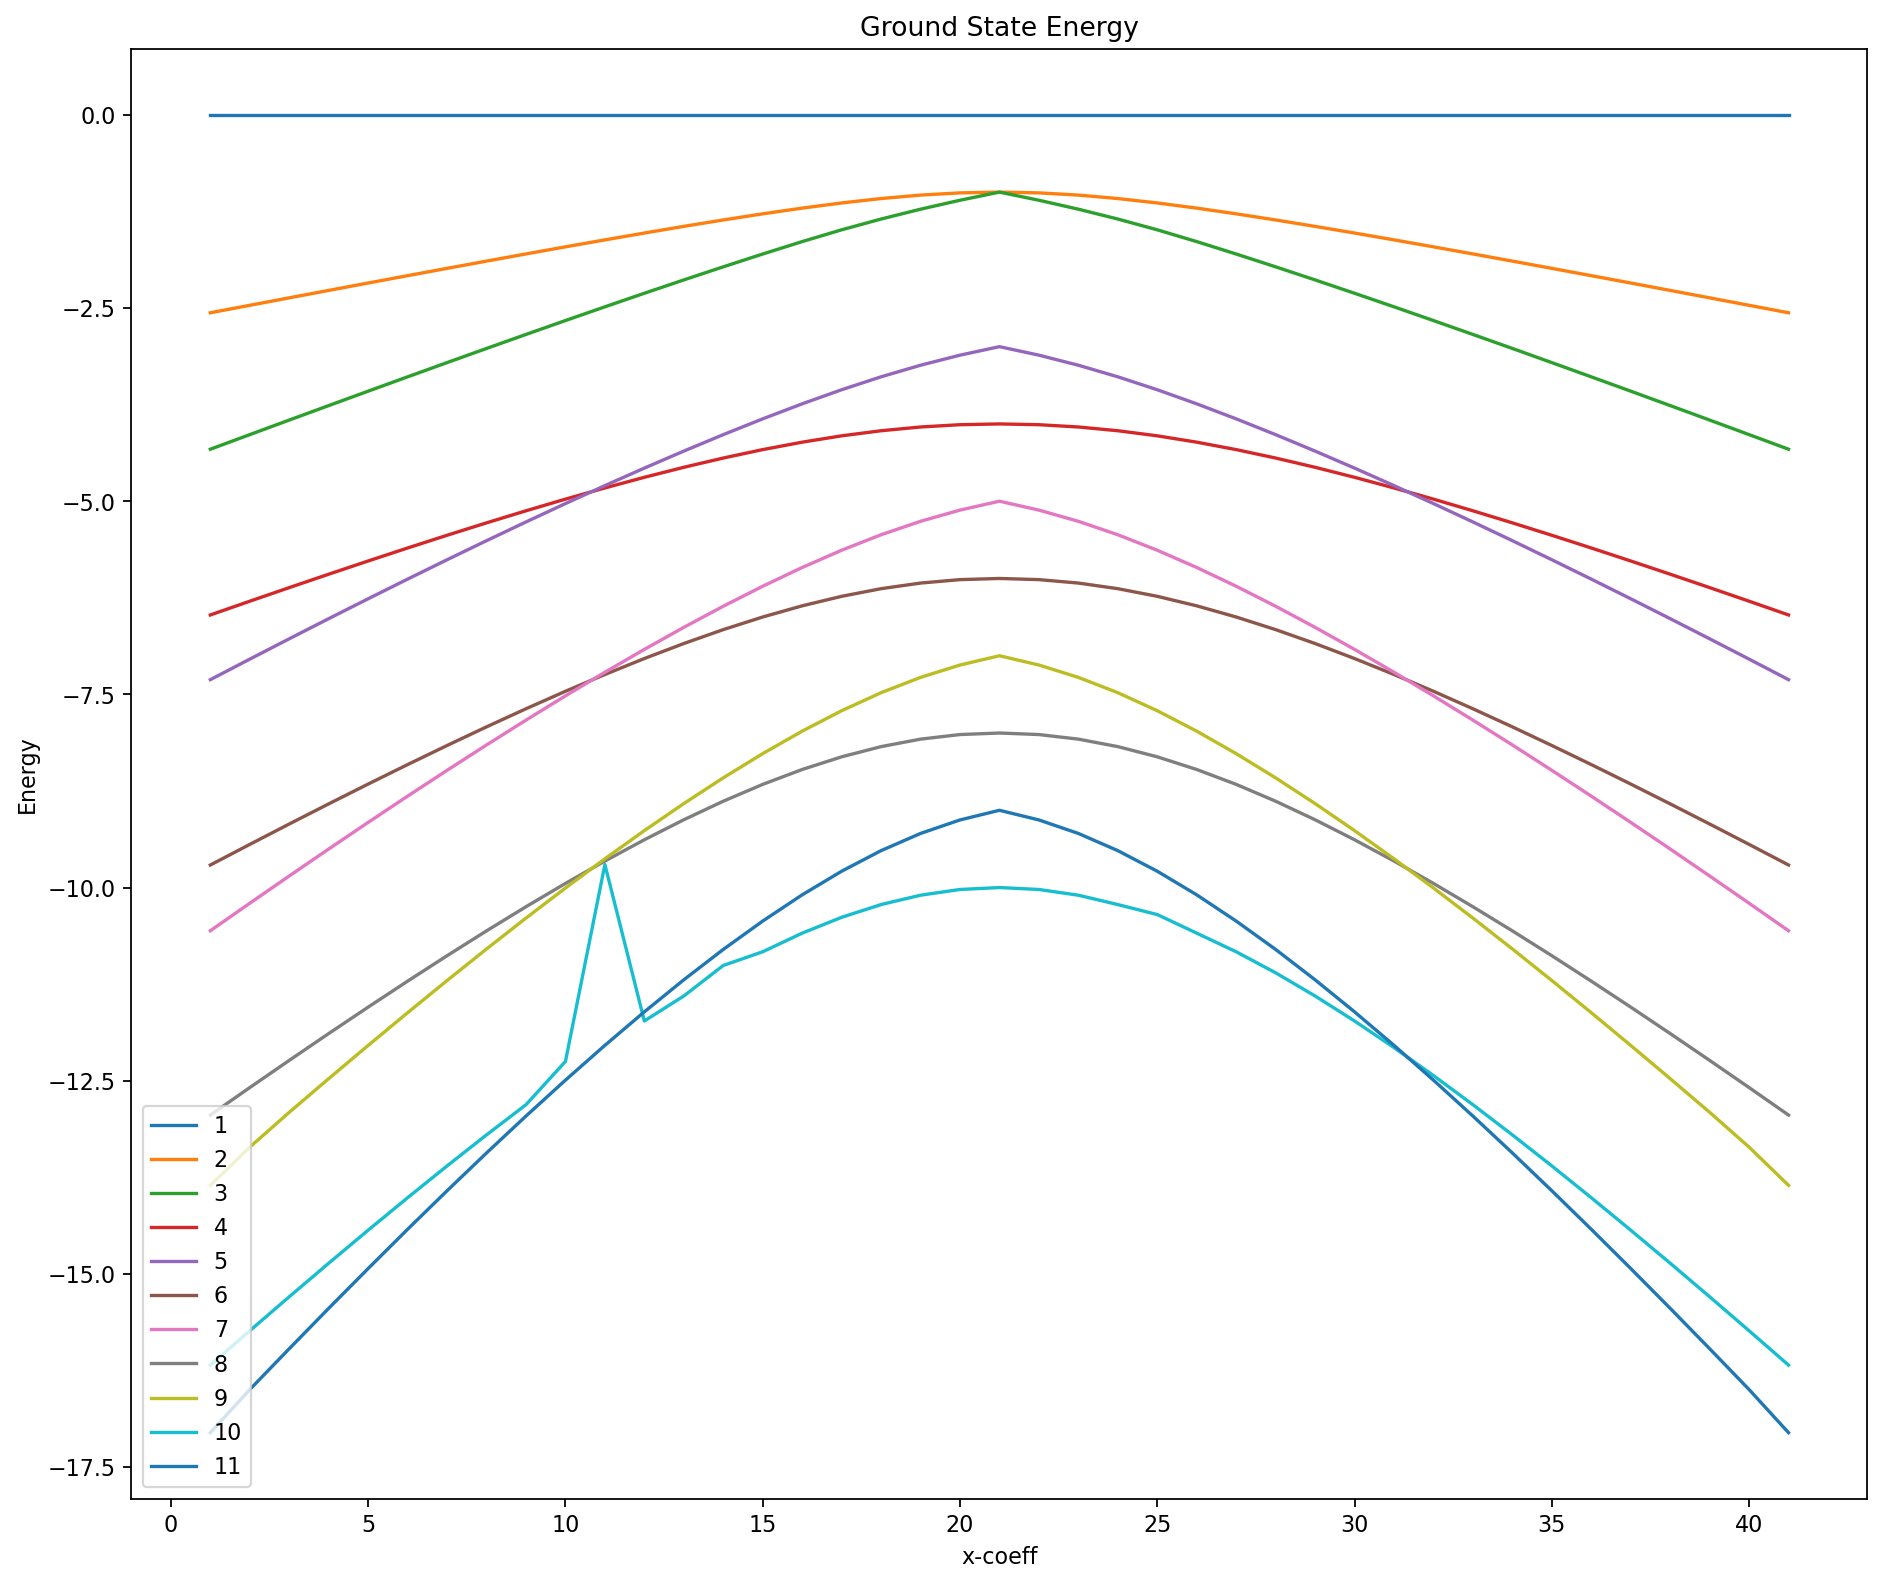

In [23]:
figure(figsize=(14, 12), dpi=160)

for i in range(1,12):
    pylab.plot(list(range(1, 42)), np.asarray(np.real(np.array(groundStates)[:, i])), label=str(i))
                                              
pylab.xlabel('x-coeff')
pylab.ylabel('Energy')
pylab.title('Ground State Energy')
pylab.legend(loc='lower left')

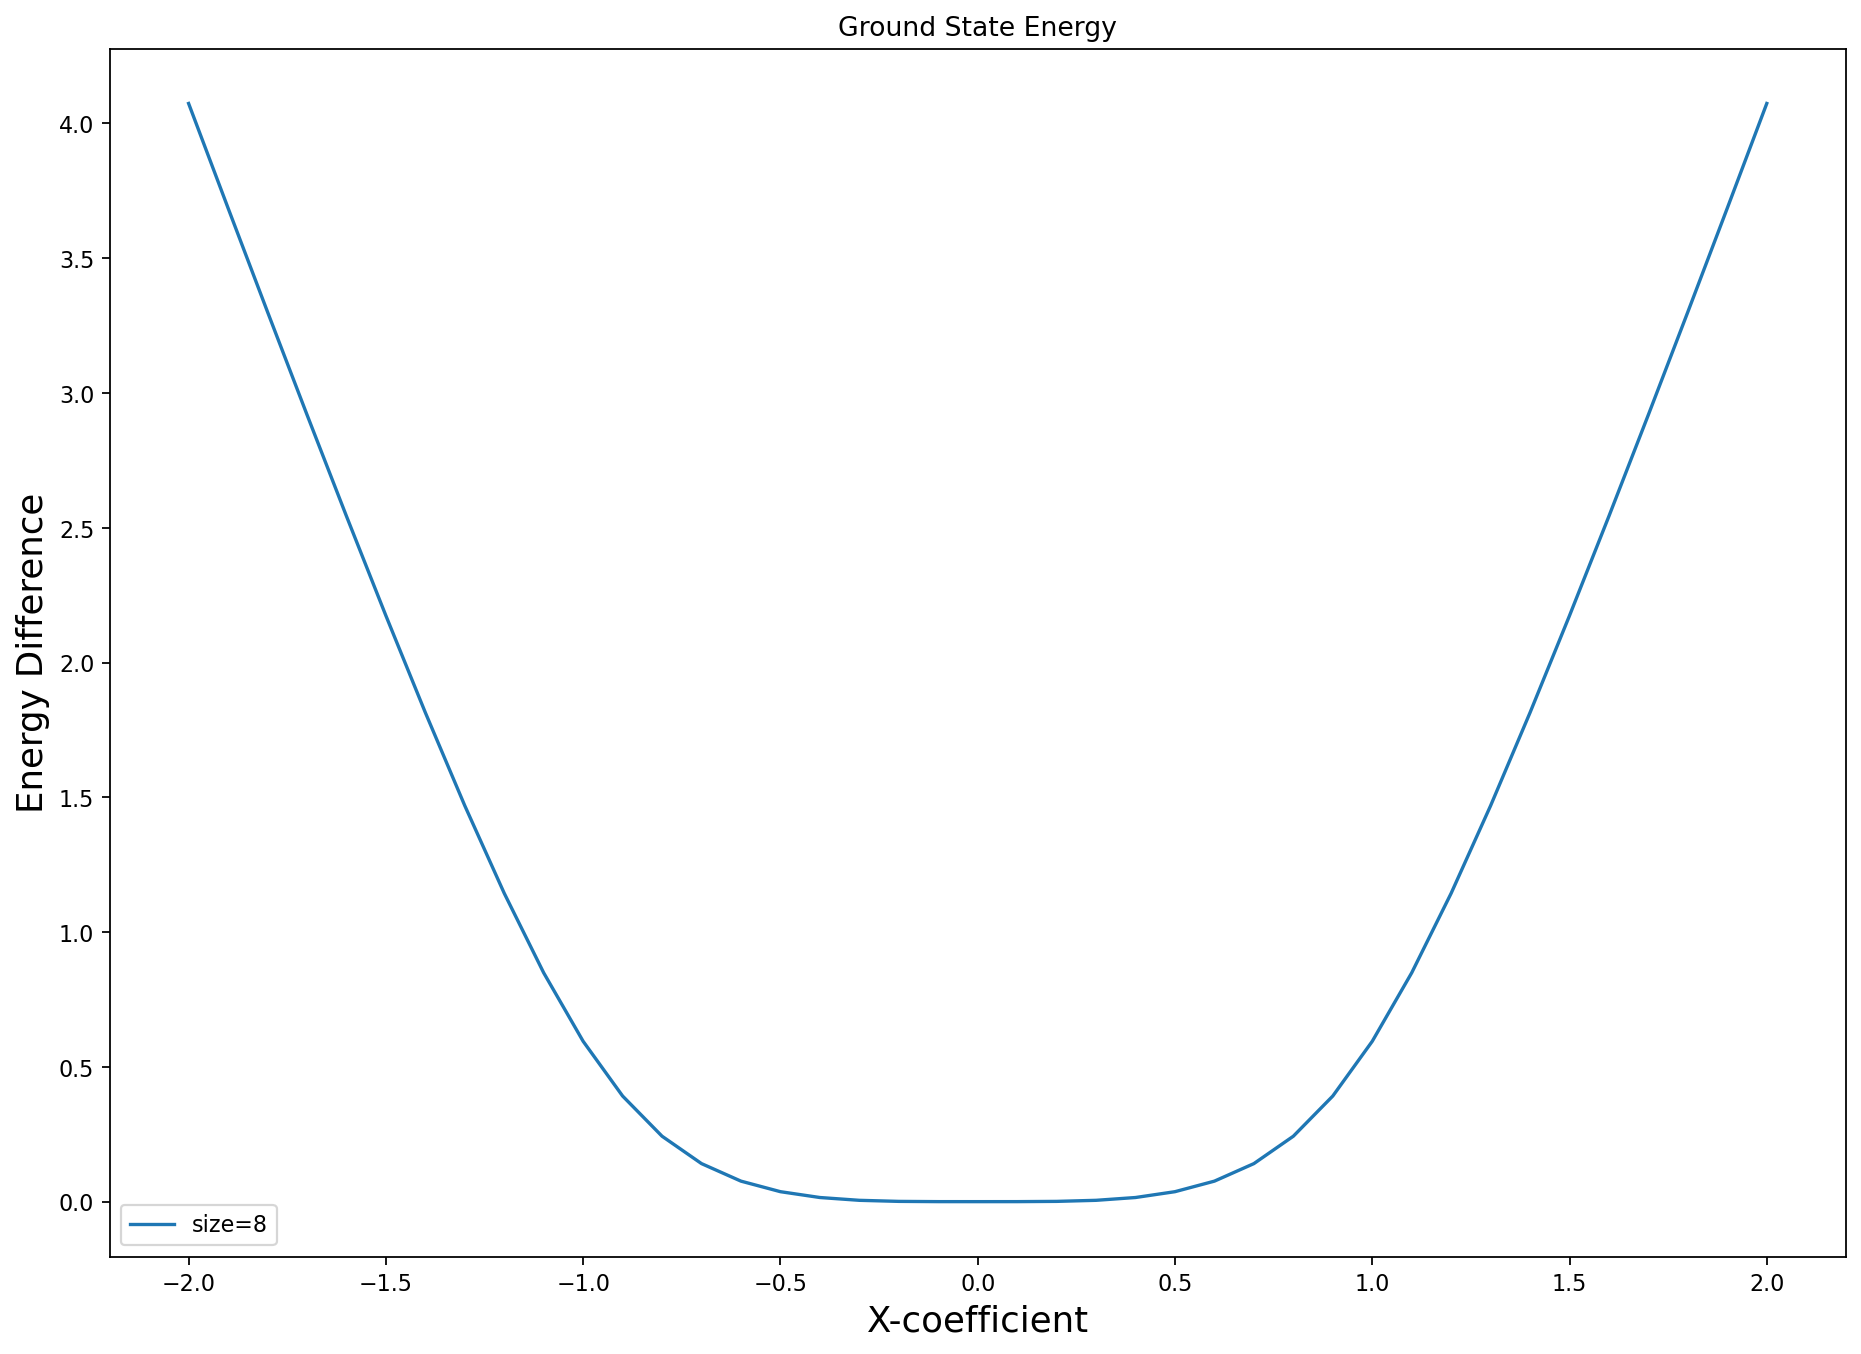

In [31]:
figure(figsize=(14, 10), dpi=160)

for i in range(8,9):
    diff = np.asarray(np.real(np.array(groundStates)[:, i])) - np.asarray(np.real(trueGroundStates[:, i]))
    pylab.plot(samples, diff, label=f"size={i}")
                                              
pylab.xlabel('X-coefficient', size = 16)
pylab.ylabel('Energy Difference', size = 16)
pylab.title('Ground State Energy')
pylab.legend(loc='lower left')
pylab.savefig('plt2.png')

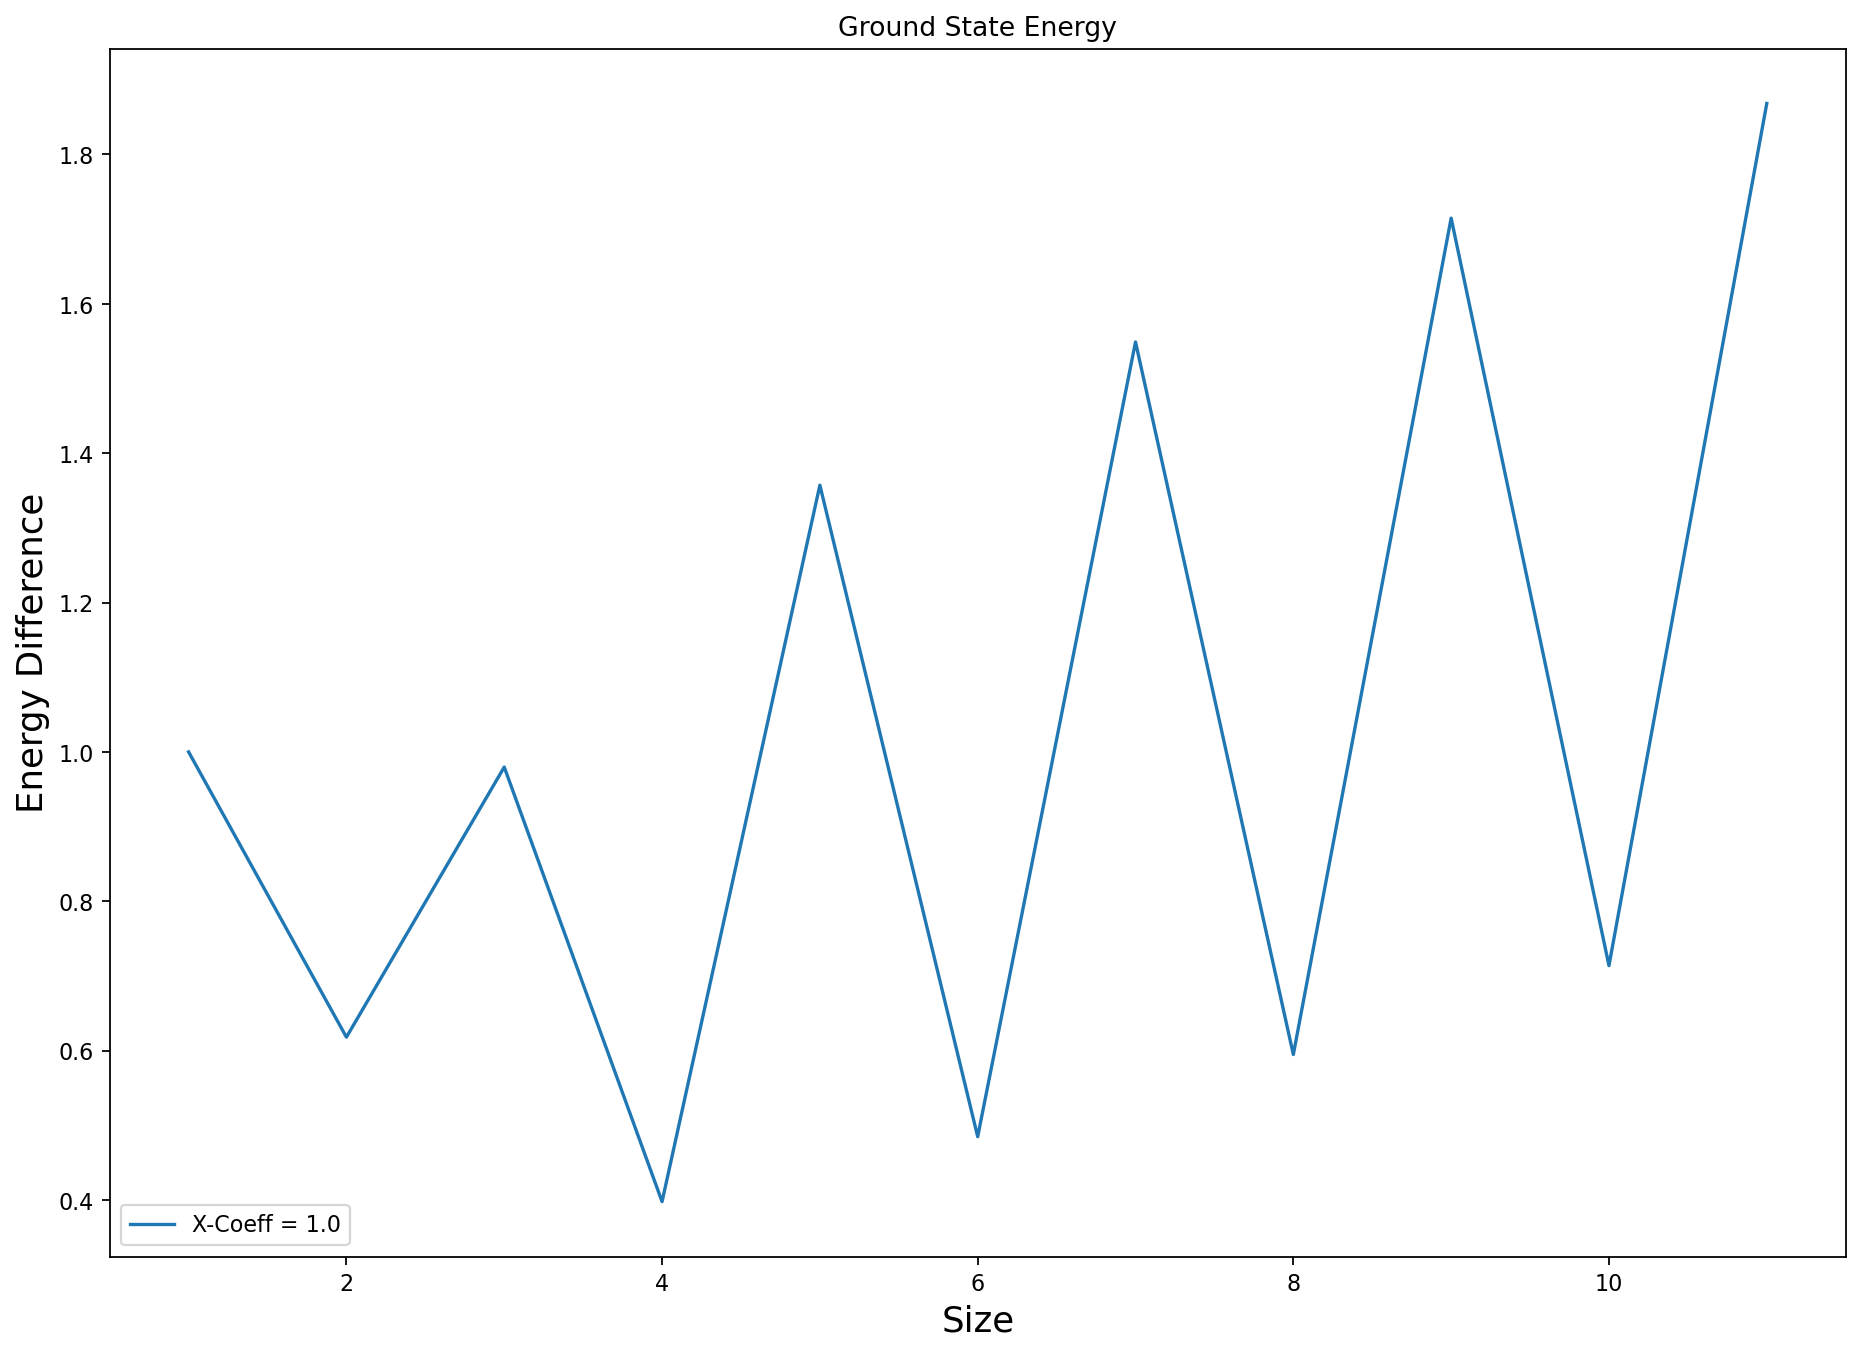

In [32]:
figure(figsize=(14, 10), dpi=160)

for i in range(s//2 + 10, s//2 + 11):
    diff = np.asarray(np.real(groundStates[i][1:]), float) - np.asarray(np.real(trueGroundStates[i][1:]), float)
    pylab.plot(list(range(1, len(groundStates[i]))), diff, label=f"X-Coeff = {samples[i]}")
pylab.xlabel('Size', size = 16)
pylab.ylabel('Energy Difference', size = 16)
pylab.title('Ground State Energy')
pylab.legend(loc='lower left')
pylab.savefig('plt4.png')

In [17]:
print(trueGroundStates)

[[  0.          -2.          -4.12310563  -6.29150262  -8.54311682
  -10.61988123 -12.76938913 -14.88646753 -17.01816447 -19.14311828
  -21.27120882]
 [  0.          -1.9         -3.92937654  -6.00294033  -8.17603546
  -10.1512486  -12.2129334  -14.23400591 -16.27432715 -18.3052991
  -20.34084655]
 [  0.          -1.8         -3.73630834  -5.71528229  -7.81322526
   -9.68578692 -11.66204633 -13.58685929 -15.53737341 -17.47470594
  -19.41884288]
 [  0.          -1.7         -3.54400903  -5.42863617  -7.45553236
   -9.22396432 -11.1179372  -12.94592945 -14.80875869 -16.65266279
  -18.50690039]
 [  0.          -1.6         -3.35261092  -5.14312668  -7.10401652
   -8.76633517 -10.58219668 -12.31231383 -14.09042044 -15.8408194
  -17.60727058]
 [  0.          -1.5         -3.16227766  -4.85889894  -6.76000855
   -8.31355733 -10.05694642 -11.68735103 -13.38500523 -15.04124236
  -16.72302491]
 [  0.          -1.4         -2.97321375  -4.5761226   -6.42517773
   -7.866412    -9.54504519 -11.072

In [18]:
print(groundStates)

[array([ 9.99990000e+03,  0.00000000e+00, -2.56155281e+00, -4.32727613e+00,
       -6.47213587e+00, -7.30950084e+00, -9.70820376e+00, -1.05590767e+01,
       -1.29442718e+01, -1.38538715e+01, -1.46833199e+01]), array([ 9.99990000e+03,  0.00000000e+00, -2.46468827e+00, -4.13823783e+00,
       -6.29418209e+00, -7.04379912e+00, -9.44127312e+00, -1.02027136e+01,
       -1.25883641e+01, -1.33591046e+01, -1.57354551e+01]), array([ 9.99990000e+03,  0.00000000e+00, -2.36815415e+00, -3.94995845e+00,
       -6.11825198e+00, -6.78058960e+00, -9.17737794e+00, -9.84991537e+00,
       -1.22365040e+01, -1.29085811e+01, -1.52956300e+01]), array([ 9.99990000e+03,  0.00000000e+00, -2.27200451e+00, -3.76252048e+00,
       -5.94461656e+00, -6.52010308e+00, -8.91692480e+00, -9.50106368e+00,
       -1.18892331e+01, -1.24730122e+01, -1.32635842e+01]), array([ 9.99990000e+03,  0.00000000e+00, -2.17630546e+00, -3.57601900e+00,
       -5.77359243e+00, -6.26259458e+00, -8.66038860e+00, -9.15658809e+00,
       -1

In [19]:
print(times)

[array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.32704973e-01, 8.78906250e-03, 8.17799568e-03, 8.79716873e-03,
        8.49008560e-03],
       [1.07452869e-01, 9.30333138e-02, 1.11892939e-01, 1.42736673e-01,
        7.02381134e-02],
       [2.87747860e-01, 2.69629955e-01, 3.89799833e-01, 1.65019035e-01,
        2.22244024e-01],
       [4.11638975e-01, 2.94414997e-01, 2.80057907e-01, 3.08272839e-01,
        4.09286976e-01],
       [4.79984999e-01, 7.36867189e-01, 6.21248007e-01, 3.96575928e-01,
        6.76591158e-01],
       [8.00769091e-01, 8.50059032e-01, 8.89765024e-01, 8.18988800e-01,
        1.13092899e+00],
       [1.37687707e+00, 1.00011992e+00, 2.14816999e+00, 1.40781903e+00,
        1.88543200e+00],
       [1.31545019e+00, 2.02985406e+00, 1.97590613e+00, 1.74905896e+00,
        3.01024675e+00],
       [3.08992195e+00, 3.06250978e+00, 4.38809013e+00, 2.48010921e+00,
        2.67842722e+00],
       [9.92760181e+00, 8.394